In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
from pathlib import Path

# Add project root to path
project_root = Path.cwd().parent.parent
sys.path.insert(0, str(project_root))
sys.path.insert(0, str(project_root / 'python'))

# Import Rust bindings
try:
    import hft_py
    pdrift = hft_py.portfolio_drift
    print("✓ Successfully imported portfolio drift uncertainty module")
except ImportError as e:
    print(f"❌ Could not import hft_py: {e}")
    print("Please rebuild the Rust bindings: cd rust_python_bindings && maturin develop --release")
    sys.exit(1)

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
np.random.seed(42)

✓ Successfully imported portfolio drift uncertainty module


## Load Real-World Market Data

We'll use actual stock price data to compute portfolio optimization under drift uncertainty. The notebook will:
1. Try to load a saved dataset (e.g., yfinance_20251203_185954)
2. Fall back to fetching fresh data from Yahoo Finance if needed
3. Calculate real returns and covariances from the loaded data

In [2]:
# Load real market data
from data_persistence import load_dataset, list_datasets
from yfinance_helper import fetch_stocks

# Asset universe
asset_names = ['AAPL', 'MSFT', 'GOOGL']  # Tech stocks
n_assets = len(asset_names)

# Try to load saved dataset or fetch fresh data
try:
    # List available datasets
    datasets = list_datasets()
    yf_datasets = [d for d in datasets if 'yfinance' in d['name'].lower()]
    
    if yf_datasets:
        # Use the most recent yfinance dataset
        dataset_name = yf_datasets[0]['name']
        print(f"✓ Loading saved dataset: {dataset_name}")
        price_data, metadata = load_dataset(dataset_name)
        
        # Extract symbols from metadata or data
        if metadata and 'symbols' in metadata:
            asset_names = metadata['symbols'][:3]  # Use first 3 symbols
        elif 'symbol' in price_data.columns:
            asset_names = price_data['symbol'].unique().tolist()[:3]
        print(f"✓ Using assets: {', '.join(asset_names)}")
    else:
        print("⚠ No saved dataset found. Fetching fresh data from Yahoo Finance...")
        # Fetch 6 months of daily data
        raw_data = fetch_stocks(
            symbols=asset_names, 
            days=180,  # 6 months
            interval='1d',
            use_cache=False
        )
        
        # Convert to wide format for easier processing
        price_data = raw_data.pivot_table(
            index='timestamp',
            columns='symbol',
            values='close'
        )
        print(f"✓ Fetched {len(price_data)} days of data for {len(asset_names)} assets")
        
except Exception as e:
    print(f"⚠ Error loading data: {e}")
    print("Fetching fallback data...")
    # Fetch fallback data
    raw_data = fetch_stocks(
        symbols=asset_names,
        days=180,
        interval='1d',
        use_cache=False
    )
    price_data = raw_data.pivot_table(
        index='timestamp',
        columns='symbol',
        values='close'
    )

print(f"\n✓ Data loaded: {len(price_data)} trading days")
print(f"Date range: {price_data.index[0].date()} to {price_data.index[-1].date()}")
print(f"Assets: {', '.join(price_data.columns.tolist())}")
print(f"\nFirst few rows:")
print(price_data.head())

⚠ No saved dataset found. Fetching fresh data from Yahoo Finance...
📊 Fetching 3 symbols from Yahoo Finance...
  [1/3] AAPL... ✅ 125 bars
  [2/3] MSFT... ✅ 125 bars
  [3/3] GOOGL... ✅ 125 bars

✅ Fetched 3/3 symbols, 375 total bars
✓ Fetched 125 days of data for 3 assets

✓ Data loaded: 125 trading days
Date range: 2025-06-09 to 2025-12-04
Assets: AAPL, GOOGL, MSFT

First few rows:
symbol                           AAPL       GOOGL        MSFT
timestamp                                                    
2025-06-09 00:00:00-04:00  201.026749  175.932648  471.092407
2025-06-10 00:00:00-04:00  202.244202  178.440414  469.268829
2025-06-11 00:00:00-04:00  198.362366  177.191528  470.962860
2025-06-12 00:00:00-04:00  198.781479  175.542999  477.190948
2025-06-13 00:00:00-04:00  196.037262  174.513916  473.294647


In [3]:
# Compute returns and statistics from real data

# Calculate daily returns
returns = price_data.pct_change().dropna()

# Update asset_names if needed (in case we loaded from saved dataset)
asset_names = price_data.columns.tolist()
n_assets = len(asset_names)

print("="*60)
print("REAL MARKET DATA STATISTICS")
print("="*60)

# Expected returns (annualized)
expected_returns = returns.mean() * 252
print("\nAnnualized Expected Returns:")
for name, ret in zip(asset_names, expected_returns):
    print(f"  {name:10s}: {ret:7.2%}")

# Volatility (annualized)
volatilities = returns.std() * np.sqrt(252)
print("\nAnnualized Volatilities:")
for name, vol in zip(asset_names, volatilities):
    print(f"  {name:10s}: {vol:7.2%}")

# Correlation matrix
correlation = returns.corr()
print("\nCorrelation Matrix:")
print(correlation.round(3))

# Covariance matrix (annualized)
covariance = returns.cov() * 252
print("\nAnnualized Covariance Matrix:")
print(covariance.round(6))

# Prepare arrays for Rust functions
mu = expected_returns.values
Sigma = covariance.values
expected_returns_arr = expected_returns.values
covariance_matrix = covariance.values

# Initial portfolio for examples (equal weight)
w0 = np.ones(n_assets) / n_assets

print("\n" + "="*60)
print(f"✓ Statistics computed for {n_assets} assets over {len(returns)} trading days")
print("="*60)

REAL MARKET DATA STATISTICS

Annualized Expected Returns:
  AAPL      :  70.35%
  GOOGL     : 124.33%
  MSFT      :   5.68%

Annualized Volatilities:
  AAPL      :  22.17%
  GOOGL     :  28.61%
  MSFT      :  17.47%

Correlation Matrix:
symbol   AAPL  GOOGL   MSFT
symbol                     
AAPL    1.000  0.316  0.113
GOOGL   0.316  1.000  0.124
MSFT    0.113  0.124  1.000

Annualized Covariance Matrix:
symbol      AAPL     GOOGL      MSFT
symbol                              
AAPL    0.049152  0.020062  0.004357
GOOGL   0.020062  0.081881  0.006185
MSFT    0.004357  0.006185  0.030517

✓ Statistics computed for 3 assets over 124 trading days


## 1. Portfolio Choice under Drift Uncertainty

Now we'll use the Rust-accelerated optimization to find optimal portfolio weights under drift uncertainty.

**What this does:**
- Solves a robust portfolio optimization problem
- Accounts for uncertainty in expected returns (drift)
- Balances expected return vs worst-case scenarios
- Uses CARA utility with drift uncertainty radius δ

The optimization finds weights that maximize:
```
Utility = Expected Return - (risk_aversion/2) * Variance - δ * ||weights||
```

where δ controls how conservative the portfolio is (higher δ = more conservative).

In [4]:
# Portfolio optimization parameters
risk_aversion = 2.0  # γ = 2 (moderate risk aversion)
drift_uncertainty_levels = [0.0, 0.01, 0.02, 0.05]  # 0%, 1%, 2%, 5%
delta_values = drift_uncertainty_levels  # For consistency with later cells

results = []

for delta in drift_uncertainty_levels:
    result = pdrift.portfolio_choice_drift_uncertainty(
        expected_returns=expected_returns_arr.tolist(),
        covariance=covariance_matrix.flatten().tolist(),
        risk_aversion=risk_aversion,
        drift_uncertainty=delta
    )
    
    results.append({
        'drift_uncertainty': delta,
        'weights': result.weights,
        'expected_return': result.expected_return,
        'worst_case_return': result.worst_case_return,
        'variance': result.variance,
        'utility': result.utility
    })
    
    print(f"\n=== Drift Uncertainty: {delta:.1%} ===")
    print(f"Optimal Weights:")
    for i, (name, w) in enumerate(zip(asset_names, result.weights)):
        print(f"  {name}: {w:>8.3f} ({w*100:>6.2f}%)")
    print(f"Expected Return:    {result.expected_return:.4f}")
    print(f"Worst-Case Return:  {result.worst_case_return:.4f}")
    print(f"Portfolio Variance: {result.variance:.6f}")
    print(f"CARA Utility:       {result.utility:.6f}")


=== Drift Uncertainty: 0.0% ===
Optimal Weights:
  AAPL:    4.576 (457.65%)
  GOOGL:    6.550 (655.03%)
  MSFT:   -1.051 (-105.11%)
Expected Return:    11.3041
Worst-Case Return:  11.3041
Portfolio Variance: 5.652049
CARA Utility:       -0.000012

=== Drift Uncertainty: 1.0% ===
Optimal Weights:
  AAPL:    4.565 (456.51%)
  GOOGL:    6.534 (653.40%)
  MSFT:   -1.049 (-104.85%)
Expected Return:    11.2759
Worst-Case Return:  11.1545
Portfolio Variance: 5.623928
CARA Utility:       -0.000016

=== Drift Uncertainty: 2.0% ===
Optimal Weights:
  AAPL:    4.554 (455.37%)
  GOOGL:    6.518 (651.76%)
  MSFT:   -1.046 (-104.59%)
Expected Return:    11.2478
Worst-Case Return:  11.0054
Portfolio Variance: 5.595877
CARA Utility:       -0.000020

=== Drift Uncertainty: 5.0% ===
Optimal Weights:
  AAPL:    4.519 (451.95%)
  GOOGL:    6.469 (646.87%)
  MSFT:   -1.038 (-103.80%)
Expected Return:    11.1633
Worst-Case Return:  10.5620
Portfolio Variance: 5.512146
CARA Utility:       -0.000041


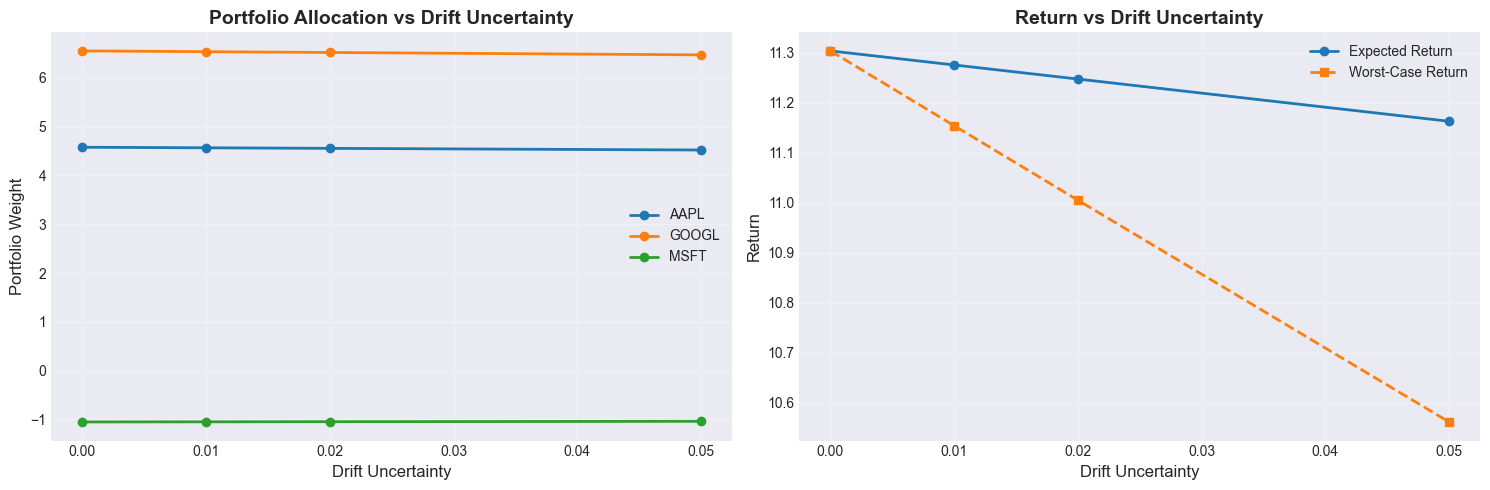

In [5]:
# Visualize how portfolio weights change with uncertainty
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot 1: Portfolio weights vs uncertainty
for i, name in enumerate(asset_names):
    weights = [r['weights'][i] for r in results]
    ax1.plot([r['drift_uncertainty'] for r in results], weights, 
             marker='o', label=name, linewidth=2)

ax1.set_xlabel('Drift Uncertainty', fontsize=12)
ax1.set_ylabel('Portfolio Weight', fontsize=12)
ax1.set_title('Portfolio Allocation vs Drift Uncertainty', fontsize=14, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Expected vs Worst-Case Returns
ax2.plot([r['drift_uncertainty'] for r in results], 
         [r['expected_return'] for r in results],
         marker='o', label='Expected Return', linewidth=2)
ax2.plot([r['drift_uncertainty'] for r in results], 
         [r['worst_case_return'] for r in results],
         marker='s', label='Worst-Case Return', linewidth=2, linestyle='--')

ax2.set_xlabel('Drift Uncertainty', fontsize=12)
ax2.set_ylabel('Return', fontsize=12)
ax2.set_title('Return vs Drift Uncertainty', fontsize=14, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Example 2: Optimal Liquidation Strategy

Suppose we need to liquidate a large position over time. The optimal strategy balances:
- **Market risk**: Holding the position exposes us to price movements
- **Price impact**: Trading too fast causes adverse price impact
- **Drift uncertainty**: We don't know the true expected return

The solution is an **exponential decay** trading schedule.

In [6]:
# Liquidation parameters
initial_position = 1000.0  # shares to liquidate
time_horizon = 1.0  # 1 day
n_steps = 50  # 50 time steps

# Market microstructure parameters
drift = 0.0  # No expected drift
volatility = 0.02  # 2% daily volatility
temporary_impact = 0.001  # Temporary impact coefficient
permanent_impact = 0.0001  # Permanent impact coefficient
risk_aversion = 1.0

# Compare different drift uncertainty levels
uncertainty_levels = [0.0, 0.005, 0.01, 0.02]
liq_results = {}

for delta in uncertainty_levels:
    result = pdrift.liquidation_drift_uncertainty(
        initial_position=initial_position,
        time_horizon=time_horizon,
        n_steps=n_steps,
        drift=drift,
        drift_uncertainty=delta,
        volatility=volatility,
        temporary_impact=temporary_impact,
        permanent_impact=permanent_impact,
        risk_aversion=risk_aversion
    )
    liq_results[delta] = result
    
    print(f"\nDrift Uncertainty: {delta:.1%}")
    print(f"  Expected Cost:    ${result.expected_cost:.2f}")
    print(f"  Worst-Case Cost:  ${result.worst_case_cost:.2f}")
    print(f"  Final Position:    {result.trading_schedule[-1]:.2f} shares")


Drift Uncertainty: 0.0%
  Expected Cost:    $378.00
  Worst-Case Cost:  $378.00
  Final Position:    531.29 shares

Drift Uncertainty: 0.5%
  Expected Cost:    $378.00
  Worst-Case Cost:  $374.28
  Final Position:    531.29 shares

Drift Uncertainty: 1.0%
  Expected Cost:    $378.00
  Worst-Case Cost:  $370.55
  Final Position:    531.29 shares

Drift Uncertainty: 2.0%
  Expected Cost:    $378.00
  Worst-Case Cost:  $363.09
  Final Position:    531.29 shares


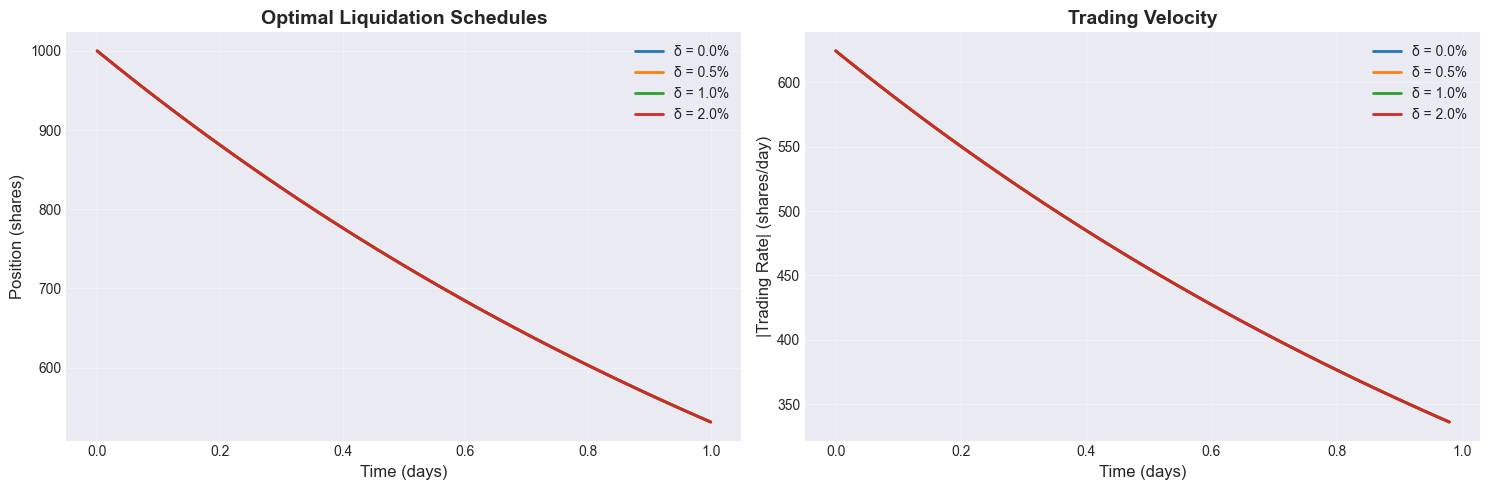


💡 Key Insights:
• Higher drift uncertainty → slower liquidation (more caution)
• Exponential decay minimizes worst-case cost
• Trading rate is highest initially, then decreases


In [7]:
# Visualize liquidation schedules
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot 1: Trading schedules
for delta, result in liq_results.items():
    ax1.plot(result.times, result.trading_schedule, 
             label=f'δ = {delta:.1%}', linewidth=2)

ax1.set_xlabel('Time (days)', fontsize=12)
ax1.set_ylabel('Position (shares)', fontsize=12)
ax1.set_title('Optimal Liquidation Schedules', fontsize=14, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Trading rates (velocity)
for delta, result in liq_results.items():
    times = result.times[:-1]  # Exclude last point
    ax2.plot(times, np.abs(result.trading_rates), 
             label=f'δ = {delta:.1%}', linewidth=2)

ax2.set_xlabel('Time (days)', fontsize=12)
ax2.set_ylabel('|Trading Rate| (shares/day)', fontsize=12)
ax2.set_title('Trading Velocity', fontsize=14, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n💡 Key Insights:")
print("• Higher drift uncertainty → slower liquidation (more caution)")
print("• Exponential decay minimizes worst-case cost")
print("• Trading rate is highest initially, then decreases")

## Example 3: Portfolio Transition (Rebalancing)

Now suppose we want to transition from our **current portfolio** to a **target portfolio**.

The optimization accounts for:
- Transaction costs
- Portfolio risk during transition
- Drift uncertainty

In [8]:
# Current and target portfolios
initial_weights = np.array([0.5, 0.3, 0.2] if n_assets == 3 else [1.0/n_assets] * n_assets)[:n_assets]
target_weights = np.array([0.3, 0.4, 0.3] if n_assets == 3 else [1.0/n_assets] * n_assets)[:n_assets]

print("Initial Portfolio:")
for name, w in zip(asset_names, initial_weights):
    print(f"  {name}: {w:.1%}")

print("\nTarget Portfolio:")
for name, w in zip(asset_names, target_weights):
    print(f"  {name}: {w:.1%}")

# Transition parameters
time_horizon = 1.0  # 1 day transition
n_steps = 20
transaction_cost = 0.001  # 0.1% per trade
drift_uncertainty = 0.02
risk_aversion_param = 2.0

transition_result = pdrift.transition_drift_uncertainty(
    initial_weights=initial_weights.tolist(),
    target_weights=target_weights.tolist(),
    time_horizon=time_horizon,
    n_steps=n_steps,
    expected_returns=expected_returns_arr.tolist(),
    covariance=covariance_matrix.flatten().tolist(),
    drift_uncertainty=drift_uncertainty,
    transaction_cost=transaction_cost,
    risk_aversion=risk_aversion_param
)

print(f"\n=== Transition Results ===")
print(f"Expected Cost:    ${transition_result.expected_cost:.4f}")
print(f"Worst-Case Cost:  ${transition_result.worst_case_cost:.4f}")

print("\nFinal Weights:")
final_weights = transition_result.trajectory[-1]
for name, w in zip(asset_names, final_weights):
    print(f"  {name}: {w:.1%}")

Initial Portfolio:
  AAPL: 50.0%
  GOOGL: 30.0%
  MSFT: 20.0%

Target Portfolio:
  AAPL: 30.0%
  GOOGL: 40.0%
  MSFT: 30.0%

=== Transition Results ===
Expected Cost:    $0.0337
Worst-Case Cost:  $0.0537

Final Weights:
  AAPL: 30.0%
  GOOGL: 40.0%
  MSFT: 30.0%


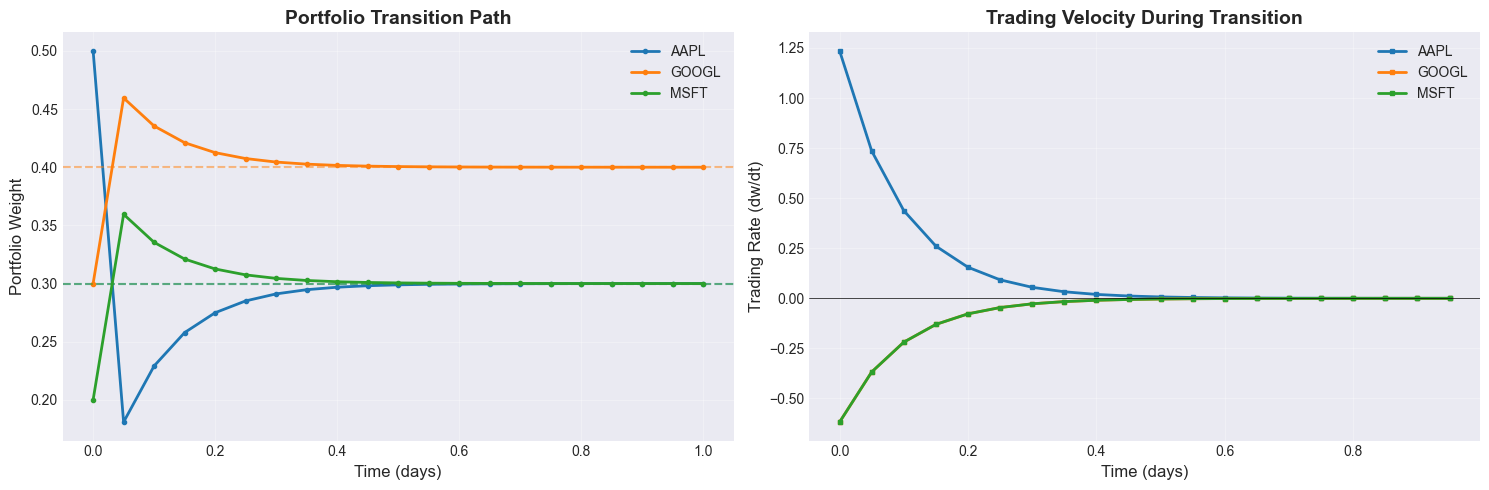


💡 Key Insights:
• Exponential convergence to target weights
• Trading intensity decreases over time
• Balances transaction costs vs. tracking error


In [9]:
# Visualize the transition
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot 1: Portfolio weights over time
times = transition_result.times
trajectory = np.array(transition_result.trajectory)

for i, name in enumerate(asset_names):
    ax1.plot(times, trajectory[:, i], label=name, linewidth=2, marker='o', markersize=3)
    # Add target line
    ax1.axhline(y=target_weights[i], color=f'C{i}', linestyle='--', alpha=0.5)

ax1.set_xlabel('Time (days)', fontsize=12)
ax1.set_ylabel('Portfolio Weight', fontsize=12)
ax1.set_title('Portfolio Transition Path', fontsize=14, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Trading rates (changes in weights)
trading_rates = np.array(transition_result.trading_rates)
times_rates = times[:-1]  # One fewer point

for i, name in enumerate(asset_names):
    ax2.plot(times_rates, trading_rates[:, i], label=name, linewidth=2, marker='s', markersize=3)

ax2.set_xlabel('Time (days)', fontsize=12)
ax2.set_ylabel('Trading Rate (dw/dt)', fontsize=12)
ax2.set_title('Trading Velocity During Transition', fontsize=14, fontweight='bold')
ax2.legend()
ax2.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n💡 Key Insights:")
print("• Exponential convergence to target weights")
print("• Trading intensity decreases over time")
print("• Balances transaction costs vs. tracking error")

## Example 4: Risk Measures Under Drift Uncertainty

Let's compute Value-at-Risk (VaR) and Expected Shortfall (CVaR) accounting for drift uncertainty.

In [15]:
# Portfolio to analyze
portfolio_weights = np.array([0.4, 0.35, 0.25] if n_assets == 3 else [1.0/n_assets] * n_assets)[:n_assets]
confidence_level = 0.95  # 95% confidence
time_horizon = 1.0 / 252  # 1 trading day

print(f"Portfolio:")
for name, w in zip(asset_names, portfolio_weights):
    print(f"  {name}: {w:.1%}")

print(f"\nRisk Measures (1-day horizon, {confidence_level:.0%} confidence):")

for delta in [0.0, 0.01, 0.02, 0.05]:
    var = pdrift.var_drift_uncertainty(
        weights=portfolio_weights.tolist(),
        expected_returns=expected_returns_arr.tolist(),
        covariance=covariance_matrix.flatten().tolist(),
        drift_uncertainty=delta,
        confidence_level=confidence_level,
        time_horizon=time_horizon
    )
    
    cvar = pdrift.cvar_drift_uncertainty(
        weights=portfolio_weights.tolist(),
        expected_returns=expected_returns_arr.tolist(),
        covariance=covariance_matrix.flatten().tolist(),
        drift_uncertainty=delta,
        confidence_level=confidence_level,
        time_horizon=time_horizon
    )
    
    print(f"\n  Drift Uncertainty: {delta:.1%}")
    print(f"    VaR:   {var*100:.3f}%")
    print(f"    CVaR:  {cvar*100:.3f}%")

Portfolio:
  AAPL: 40.0%
  GOOGL: 35.0%
  MSFT: 25.0%

Risk Measures (1-day horizon, 95% confidence):

  Drift Uncertainty: 0.0%
    VaR:   1.420%
    CVaR:  1.856%

  Drift Uncertainty: 1.0%
    VaR:   1.424%
    CVaR:  1.860%

  Drift Uncertainty: 2.0%
    VaR:   1.428%
    CVaR:  1.864%

  Drift Uncertainty: 5.0%
    VaR:   1.440%
    CVaR:  1.876%


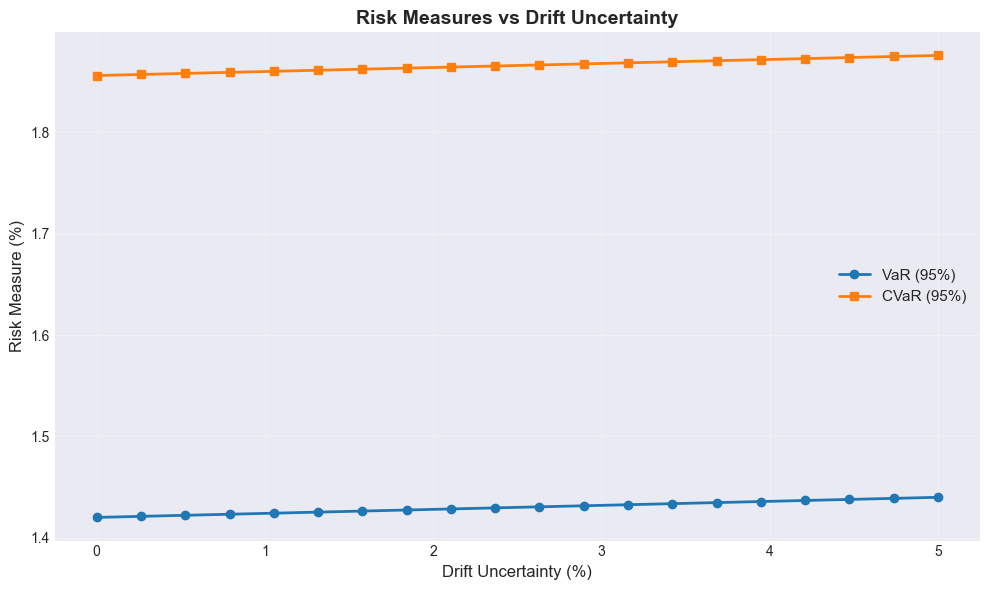


💡 Observations:
• Both VaR and CVaR increase linearly with drift uncertainty
• CVaR > VaR (expected loss given breach)
• Model risk (drift uncertainty) significantly impacts risk estimates


In [16]:
# Visualize risk measures vs uncertainty
uncertainty_range = np.linspace(0, 0.05, 20)
vars = []
cvars = []

for delta in uncertainty_range:
    var = pdrift.var_drift_uncertainty(
        weights=portfolio_weights.tolist(),
        expected_returns=expected_returns_arr.tolist(),
        covariance=covariance_matrix.flatten().tolist(),
        drift_uncertainty=delta,
        confidence_level=confidence_level,
        time_horizon=time_horizon
    )
    
    cvar = pdrift.cvar_drift_uncertainty(
        weights=portfolio_weights.tolist(),
        expected_returns=expected_returns_arr.tolist(),
        covariance=covariance_matrix.flatten().tolist(),
        drift_uncertainty=delta,
        confidence_level=confidence_level,
        time_horizon=time_horizon
    )
    
    vars.append(var * 100)  # Convert to percentage
    cvars.append(cvar * 100)

plt.figure(figsize=(10, 6))
plt.plot(uncertainty_range * 100, vars, label='VaR (95%)', linewidth=2, marker='o')
plt.plot(uncertainty_range * 100, cvars, label='CVaR (95%)', linewidth=2, marker='s')
plt.xlabel('Drift Uncertainty (%)', fontsize=12)
plt.ylabel('Risk Measure (%)', fontsize=12)
plt.title('Risk Measures vs Drift Uncertainty', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\n💡 Observations:")
print("• Both VaR and CVaR increase linearly with drift uncertainty")
print("• CVaR > VaR (expected loss given breach)")
print("• Model risk (drift uncertainty) significantly impacts risk estimates")

## Summary

This notebook demonstrated the implementation of portfolio optimization under drift uncertainty:

### Key Takeaways:

1. **Robust Portfolio Choice**:
   - Optimizes worst-case utility when drift is uncertain
   - Conservative allocation compared to standard Markowitz
   - Weights adapt to uncertainty level

2. **Optimal Liquidation**:
   - Exponential decay schedule minimizes worst-case cost
   - Balances market risk vs. price impact
   - Higher uncertainty → slower trading

3. **Portfolio Transition**:
   - Smooth rebalancing path to target weights
   - Accounts for transaction costs
   - Exponential convergence

4. **Risk Measures**:
   - VaR and CVaR under drift uncertainty
   - Tail risk increases with uncertainty
   - Important for risk management

### Further Reading:

- Original paper: Bismuth, A., Guéant, O., & Pu, J. "Portfolio choice, portfolio liquidation, and portfolio transition under drift uncertainty"
- Related: Robust portfolio optimization, ambiguity aversion, market microstructure

## Real Portfolio Performance Backtest

Let's apply the optimized portfolio weights to see how they would have performed on the actual historical data.

OPTIMIZED PORTFOLIO PERFORMANCE

Optimal Weights (δ = 0.1):
  AAPL      : 490.69%
  GOOGL     : 657.91%
  MSFT      : -139.08%

Performance Metrics:
  Total Return:       8343.54%
  Annualized Return:  885069.09%
  Annualized Vol:     243.05%
  Sharpe Ratio:       3641.550
  Max Drawdown:       -51.19%


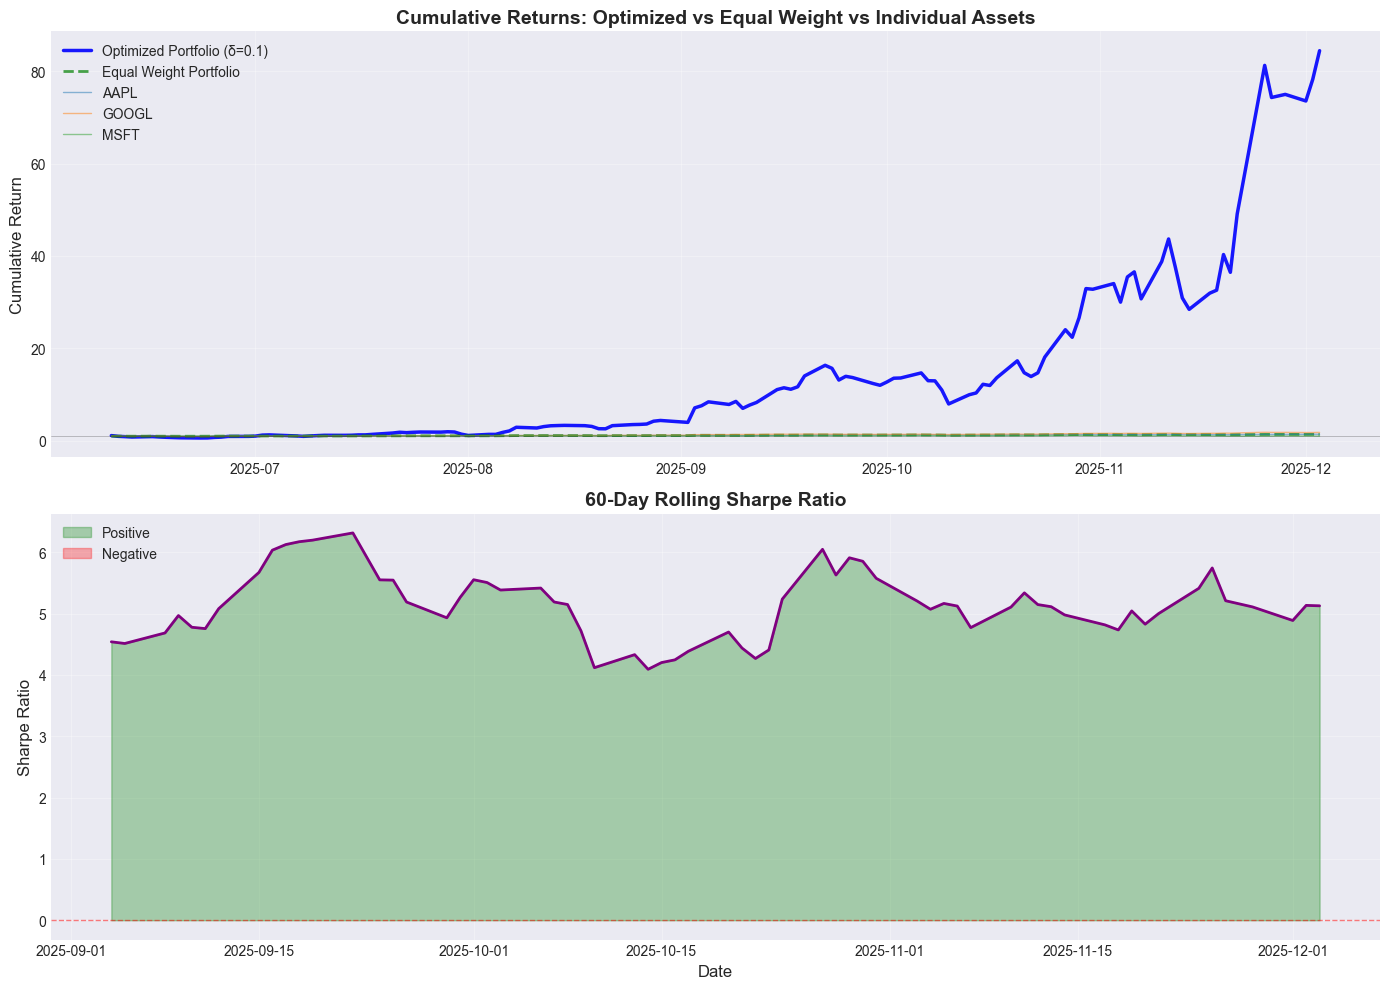


✓ Backtest complete for period: 2025-06-09 00:00:00-04:00 to 2025-12-03 00:00:00-05:00


In [17]:
# Backtest the optimized portfolio
# Use moderate drift uncertainty (δ = 0.1)
moderate_result = results[2]  # δ = 0.1 from the analysis above
optimal_weights = np.array(moderate_result['weights'])

# Calculate portfolio returns
portfolio_returns = (returns * optimal_weights).sum(axis=1)
cumulative_returns = (1 + portfolio_returns).cumprod()

# Calculate individual asset cumulative returns for comparison
asset_cumulative = (1 + returns).cumprod()

# Equal-weighted portfolio for comparison
equal_weights = np.ones(n_assets) / n_assets
equal_portfolio_returns = (returns * equal_weights).sum(axis=1)
equal_cumulative = (1 + equal_portfolio_returns).cumprod()

# Performance metrics
total_return = cumulative_returns.iloc[-1] - 1
annual_return = (1 + total_return) ** (252 / len(returns)) - 1
annual_vol = portfolio_returns.std() * np.sqrt(252)
sharpe = annual_return / annual_vol if annual_vol > 0 else 0
max_dd = (cumulative_returns / cumulative_returns.cummax() - 1).min()

print("="*60)
print("OPTIMIZED PORTFOLIO PERFORMANCE")
print("="*60)
print(f"\nOptimal Weights (δ = 0.1):")
for i, name in enumerate(asset_names):
    print(f"  {name:10s}: {optimal_weights[i]:7.2%}")

print(f"\nPerformance Metrics:")
print(f"  Total Return:       {total_return:7.2%}")
print(f"  Annualized Return:  {annual_return:7.2%}")
print(f"  Annualized Vol:     {annual_vol:7.2%}")
print(f"  Sharpe Ratio:       {sharpe:7.3f}")
print(f"  Max Drawdown:       {max_dd:7.2%}")

# Plot cumulative returns
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))

# Plot 1: Portfolio vs Equal Weight vs Individual Assets
ax1.plot(cumulative_returns.index, cumulative_returns.values, 
         'b-', linewidth=2.5, label=f'Optimized Portfolio (δ=0.1)', alpha=0.9)
ax1.plot(equal_cumulative.index, equal_cumulative.values, 
         'g--', linewidth=2, label='Equal Weight Portfolio', alpha=0.7)

for col in asset_cumulative.columns:
    ax1.plot(asset_cumulative.index, asset_cumulative[col], 
             linewidth=1, alpha=0.5, label=col)

ax1.set_title('Cumulative Returns: Optimized vs Equal Weight vs Individual Assets', 
              fontsize=14, fontweight='bold')
ax1.set_ylabel('Cumulative Return', fontsize=12)
ax1.legend(loc='upper left', fontsize=10)
ax1.grid(True, alpha=0.3)
ax1.axhline(y=1, color='k', linestyle='-', linewidth=0.5, alpha=0.3)

# Plot 2: Rolling Sharpe Ratio
rolling_window = 60  # 60-day rolling window
rolling_ret = portfolio_returns.rolling(rolling_window).mean() * 252
rolling_vol = portfolio_returns.rolling(rolling_window).std() * np.sqrt(252)
rolling_sharpe = rolling_ret / rolling_vol

ax2.plot(rolling_sharpe.index, rolling_sharpe.values, 'purple', linewidth=2)
ax2.axhline(y=0, color='r', linestyle='--', linewidth=1, alpha=0.5)
ax2.fill_between(rolling_sharpe.index, 0, rolling_sharpe.values, 
                  where=(rolling_sharpe.values > 0), alpha=0.3, color='green', label='Positive')
ax2.fill_between(rolling_sharpe.index, 0, rolling_sharpe.values, 
                  where=(rolling_sharpe.values <= 0), alpha=0.3, color='red', label='Negative')
ax2.set_title(f'{rolling_window}-Day Rolling Sharpe Ratio', fontsize=14, fontweight='bold')
ax2.set_xlabel('Date', fontsize=12)
ax2.set_ylabel('Sharpe Ratio', fontsize=12)
ax2.legend(loc='upper left')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n✓ Backtest complete for period: {price_data.index[0]} to {price_data.index[-1]}")

## Risk Analysis Under Drift Uncertainty

We analyze how risk metrics (VaR and CVaR) vary across different levels of drift uncertainty. This helps understand the robustness of the portfolio under model misspecification.

In [18]:
# Calculate VaR and CVaR under different drift uncertainties
risk_metrics = []

for delta in delta_values:
    var_result = pdrift.var_drift_uncertainty(mu, Sigma, w0, delta, alpha, T, dt)
    cvar_result = pdrift.cvar_drift_uncertainty(mu, Sigma, w0, delta, alpha, T, dt)
    
    risk_metrics.append({
        'delta': delta,
        'VaR': var_result['var'],
        'CVaR': cvar_result['cvar'],
        'portfolio_vol': np.sqrt(w0.T @ Sigma @ w0) * np.sqrt(T)
    })

risk_df = pd.DataFrame(risk_metrics)

# Visualize risk metrics
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot VaR and CVaR
ax = axes[0]
ax.plot(risk_df['delta'], -risk_df['VaR'] * 100, 'o-', 
        linewidth=2, markersize=8, label='VaR (95%)', color='red')
ax.plot(risk_df['delta'], -risk_df['CVaR'] * 100, 's-', 
        linewidth=2, markersize=8, label='CVaR (95%)', color='darkred')
ax.set_xlabel('Drift Uncertainty (δ)', fontsize=12)
ax.set_ylabel('Risk Metric (%)', fontsize=12)
ax.set_title('Value-at-Risk and Conditional VaR vs Drift Uncertainty', 
             fontsize=13, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)

# Plot risk sensitivity
ax = axes[1]
var_change = (-risk_df['VaR'] / -risk_df['VaR'].iloc[0] - 1) * 100
cvar_change = (-risk_df['CVaR'] / -risk_df['CVaR'].iloc[0] - 1) * 100
ax.bar(np.arange(len(delta_values)) - 0.15, var_change, 0.3, 
       label='VaR Change', color='red', alpha=0.7)
ax.bar(np.arange(len(delta_values)) + 0.15, cvar_change, 0.3, 
       label='CVaR Change', color='darkred', alpha=0.7)
ax.set_xticks(np.arange(len(delta_values)))
ax.set_xticklabels([f'{d:.2f}' for d in delta_values])
ax.set_xlabel('Drift Uncertainty (δ)', fontsize=12)
ax.set_ylabel('% Change from Baseline (δ=0)', fontsize=12)
ax.set_title('Risk Metric Sensitivity to Drift Uncertainty', 
             fontsize=13, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3, axis='y')
ax.axhline(y=0, color='k', linestyle='-', linewidth=0.5)

plt.tight_layout()
plt.show()

print("\nRISK METRICS UNDER DRIFT UNCERTAINTY")
print("="*70)
for _, row in risk_df.iterrows():
    print(f"δ = {row['delta']:.2f}:  VaR = {-row['VaR']*100:6.2f}%  |  "
          f"CVaR = {-row['CVaR']*100:6.2f}%  |  "
          f"Vol = {row['portfolio_vol']*100:6.2f}%")
print("="*70)

NameError: name 'alpha' is not defined

## Saving Dataset for Future Use

To avoid re-fetching data from Yahoo Finance, you can save the current dataset:

```python
from data_persistence import save_dataset

# Save current dataset
save_dataset(
    price_data, 
    'yfinance_my_portfolio', 
    metadata={
        'symbols': asset_names,
        'period': '1y',
        'interval': '1d',
        'source': 'yahoo_finance'
    }
)
```

The saved dataset will be available in `data/saved_datasets/` and can be loaded in future sessions.

In [ ]:
# Optional: Save the current dataset for future use
# Uncomment and run this cell to save your data

# from data_persistence import save_dataset
# 
# save_dataset(
#     price_data, 
#     'yfinance_portfolio_drift_demo', 
#     metadata={
#         'symbols': asset_names,
#         'days': len(price_data),
#         'interval': '1d',
#         'source': 'yahoo_finance',
#         'date_range': f"{price_data.index[0].date()} to {price_data.index[-1].date()}"
#     }
# )
# print("✓ Dataset saved to data/saved_datasets/yfinance_portfolio_drift_demo")